In [272]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns  # 如果想要更方便地可视化混淆矩阵，可以使用 seaborn
from tqdm import tqdm   # 用于进度条
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder

| 方法 | 适用场景 | 优点 | 缺点 |
|------|----------|------|------|
| **方差过滤** | 特征数据较多，但部分特征几乎无变化 | 简单高效 | 可能误删重要特征 |
| **相关性分析** | 需要快速找出与目标变量相关的特征 | 可解释性强 | 仅适用于线性关系 |
| **递归特征消除 (RFE)** | 需要选择固定数量的重要特征 | 适用于各种模型 | 计算量较大 |
| **Lasso (L1 正则化)** | 数据含有冗余特征 | 可自动筛选特征 | 只适用于线性模型 |
| **随机森林特征选择** | 适用于分类问题 | 适用于高维数据 | 计算量大 |
| **LightGBM 重要性** | 数据量大、特征多 | 高效、适用于大规模数据 | 需要调整超参数 |


In [273]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

def rfe_selection(df, target_column, n_features_to_select=5):
    """
    使用RFE（递归特征消除）选择特征
    
    参数:
    df: DataFrame - 输入数据集
    target_column: str - 目标变量列名
    n_features_to_select: int - 选择的特征数量（默认5）
    
    返回:
    selected_features: list - 选出的特征名列表
    """
    X = df.drop([target_column], axis=1)
    y = df[target_column]

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    selector = RFE(model, n_features_to_select=n_features_to_select)
    selector.fit(X, y)
    
    selected_features = X.columns[selector.support_].tolist()
    return selected_features


In [274]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

def lasso_selection(df, target_column, alpha=0.01):
    """
    使用 Lasso 回归进行特征选择
    
    参数:
    df: DataFrame - 输入数据集
    target_column: str - 目标变量列名
    alpha: float - Lasso 回归的正则化参数（默认0.01）
    
    返回:
    selected_features: list - 选出的特征名列表
    """
    X = df.drop([target_column], axis=1)
    y = df[target_column]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    lasso = Lasso(alpha=alpha)
    lasso.fit(X_scaled, y)

    selected_features = X.columns[lasso.coef_ != 0].tolist()
    return selected_features


In [275]:
import lightgbm as lgb

def lgbm_feature_selection(df, target_column, num_features=10):
    """
    使用 LightGBM 选择特征
    
    参数:
    df: DataFrame - 输入数据集
    target_column: str - 目标变量列名
    num_features: int - 选择的特征数量（默认10）
    
    返回:
    selected_features: list - 选出的特征名列表
    """
    X = df.drop([target_column], axis=1)
    y = df[target_column]

    model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)

    feature_importances = pd.Series(model.feature_importances_, index=X.columns)
    selected_features = feature_importances.nlargest(num_features).index.tolist()
    return selected_features


In [276]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

def select_features_with_rf(df, target_column, test_size=0.3, n_estimators=100, random_state=42):
    """
    使用随机森林进行特征选择
    
    参数:
    df: DataFrame - 输入数据集
    target_column: str - 目标变量列名
    test_size: float - 测试集比例 (默认 0.3)
    n_estimators: int - 随机森林树的数量 (默认 100)
    random_state: int - 随机种子，确保结果可复现 (默认 42)
    
    返回:
    selected_features: list - 选出的特征名列表
    X_train_selected: DataFrame - 训练集筛选后的特征
    X_test_selected: DataFrame - 测试集筛选后的特征
    y_train: Series - 训练集目标变量
    y_test: Series - 测试集目标变量
    """
    
    # 1. 分离特征和目标变量
    #df = pd.read_csv(train_path)
    #X, y = preprocess_data(df)

    X = df.drop([target_column], axis=1)
    y = df[target_column]

    # 2. 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    #print(f"训练集: {X_train.shape}, 测试集: {X_test.shape}")

    # 3. 训练随机森林模型
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    rf.fit(X_train, y_train)

    # 4. 使用 SelectFromModel 进行特征选择
    sel = SelectFromModel(rf)
    sel.fit(X_train, y_train)

    # 5. 获取被选中的特征
    selected_features = X_train.columns[sel.get_support()].tolist()


    return selected_features

In [277]:
# -----------------------------------------------------------------------------
# 1. 数据预处理函数
# -----------------------------------------------------------------------------
def preprocess_data(df):
    """
    对数据进行预处理：
    1. 将object类型或可能是字符串类型的特征进行编码（标签编码）
    2. 提取特征X和标签y
    """
    # 假设最后一列class为标签
    # 如果列名为 'class'，则：
    if 'class' not in df.columns:
        raise ValueError("DataFrame 中未找到 'class' 列，请检查数据。")
    
    #df = df.drop(columns=['id', 'attack_cat'])  # 删除无用列

    # 版本 1: Label Encoding (适合决策树、随机森林、XGBoost)
    categorical_columns = ['protocol_type', 'service', 'flag']
    df_label = df.copy()
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df_label[col] = le.fit_transform(df[col])
        label_encoders[col] = le  # 存储编码器，便于逆向转换
    
    print("Label Encoding 完成...")

    # 标准化数值特征（不包括 label）
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    numerical_columns.remove('class')  # 不对标签列进行标准化
    
    # 标准化方法
    scaler_standard = StandardScaler()
    scaler_minmax = MinMaxScaler()
    scaler_robust = RobustScaler()

    df_standard = df_label.copy()
    #df_minmax = df_label.copy()
    #df_robust = df_label.copy()

    df_standard[numerical_columns] = scaler_standard.fit_transform(df_standard[numerical_columns])
    
    print("标准化数值特征完成...")
    #df_minmax[numerical_columns] = scaler_minmax.fit_transform(df_minmax[numerical_columns])
    #df_robust[numerical_columns] = scaler_robust.fit_transform(df_robust[numerical_columns])

    #select_features=select_features_with_rf(df_standard, 'label')
    #df_standard=df_standard[select_features+['label']]

    # 分离特征和标签
    #X = df_standard.drop('label', axis=1)
    #y = df_standard['label']

    return df_standard

In [278]:
def preprocess_data_select(df_standard): 
    
    select_features=select_features_with_rf(df_standard, 'class')
    df_standard=df_standard[select_features+['class']]
    
    return df_standard, select_features

In [279]:
# -----------------------------------------------------------------------------
# 2. 模型选择函数
# -----------------------------------------------------------------------------
def choose_model(model_name='RF'):
    """
    根据输入的模型名称，返回对应的机器学习模型实例。
    可根据需求在此扩展更多模型。
    """
    model_name = model_name.lower()
    if model_name == 'dt':
        # 决策树
        return DecisionTreeClassifier(random_state=42)
    elif model_name == 'rf':
        # 随机森林
        return RandomForestClassifier(n_estimators=100, random_state=42)
    elif model_name == 'svm':
        # 支持向量机
        return SVC(kernel='rbf', probability=True, random_state=42)
    elif model_name == 'knn':
        # K近邻
        return KNeighborsClassifier(n_neighbors=5)
    elif model_name == 'gbm':
        # 梯度提升
        return GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
    elif model_name == 'lr':
        # 逻辑回归
        return LogisticRegression(max_iter=1000, random_state=42)
    elif model_name == 'xgboost':
        # XGBoost
        return XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    else:
        print(f"未匹配到指定模型 {model_name}，默认使用随机森林 (RF)。")
        return RandomForestClassifier(n_estimators=100, random_state=42)

In [280]:
# -----------------------------------------------------------------------------
# 3. 训练函数
# -----------------------------------------------------------------------------
def train_model(model, train_path):
    """
    使用给定的模型和训练集路径对模型进行训练。
    返回训练好的模型，以及预处理后的训练特征和标签。
    """
    print(f"开始加载训练数据：{train_path}")
    df_train = pd.read_csv(train_path)
    print("开始对训练数据进行预处理...")
    
    df_train = preprocess_data(df_train)
    df_train,select_features= preprocess_data_select(df_train)
    
    # 分离特征和标签
    X_train = df_train.drop('class', axis=1)
    y_train = df_train['class']

    #print(X_train)

    print("开始训练模型...")
    # 这里加一个进度条来模拟训练过程；一般情况下，训练过程本身不一定能直接在tqdm中显示（要看模型是否支持迭代输出）
    for _ in tqdm(range(1), desc="Training"):
        model.fit(X_train, y_train)
    print("训练完成！")
    return model, X_train, y_train ,select_features

In [289]:
# -----------------------------------------------------------------------------
# 4. 测试函数
# -----------------------------------------------------------------------------
def test_model(model, test_path, select_features, batch_size=1000):
    """
    使用给定的模型和测试集路径对模型进行测试。
    返回评估指标分数，并可视化混淆矩阵。
    使用批量预测来提升速度，同时保留进度条。
    
    参数:
    - model: 训练好的模型
    - test_path: 测试集CSV文件路径
    - batch_size: 每批预测的数据量大小
    """

    print(f"开始加载测试数据：{test_path}")
    df_test = pd.read_csv(test_path)

    print("开始对测试数据进行预处理...")

    df_test = preprocess_data(df_test)
    #print(df_test.columns)
    #df_test, select_features_test= preprocess_data_select(df_test)
    #print(select_features)

    # 分离特征和标签
    X_test = df_test.drop('class', axis=1)
    y_test = df_test['class']
    X_test = X_test[select_features]

    #print(X_test)

    print("开始预测...")
    # 如果不需要进度条，或对小数据集，直接使用 model.predict(X_test) 即可:
    # y_pred = model.predict(X_test)
    #
    # 下面使用批量预测方式 + tqdm 进度条的写法：
    predictions = []
    # range(0, len(X_test), batch_size) 可以把测试集分成若干批次
    for start_idx in tqdm(range(0, len(X_test), batch_size), desc="Predicting"):
        end_idx = min(start_idx + batch_size, len(X_test))
        # 按批次取出数据
        X_batch = X_test.iloc[start_idx:end_idx]
        # 一次预测该批次所有样本
        batch_preds = model.predict(X_batch)
        # 收集到predictions中
        predictions.extend(batch_preds)
    # 转为数组
    y_pred = np.array(predictions)
    # 计算指标
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    print(f"\n测试结果：\nAccuracy = {acc:.20f}\nPrecision = {precision:.20f}\nRecall = {recall:.20f}\nF1-Score = {f1:.20f}")
    # 可视化混淆矩阵
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    return acc, precision, recall, f1

In [304]:
# -----------------------------------------------------------------------------
# 主流程示例
# -----------------------------------------------------------------------------
selected_model_name = 'RF'  # 'RF', 'SVM', 'KNN', 'GBM', 'DT', 'LR', 'xgboost' 等
model = choose_model(selected_model_name)
# 设置训练集和测试集路径
train_csv_path = 'NSL_KDD_train_split.csv'
# 训练模型
model, X_train, y_train ,select_features = train_model(model, train_csv_path)
#print(select_features)

开始加载训练数据：NSL_KDD_train_split.csv
开始对训练数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始训练模型...


Training: 100%|██████████| 1/1 [00:03<00:00,  3.47s/it]

训练完成！


开始加载测试数据：NSL_KDD_PGD_Adversarial.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 116.04it/s]


测试结果：
Accuracy = 0.92509250925092512130
Precision = 0.93120416296953778534
Recall = 0.92509250925092512130
F1-Score = 0.92521324669906479521


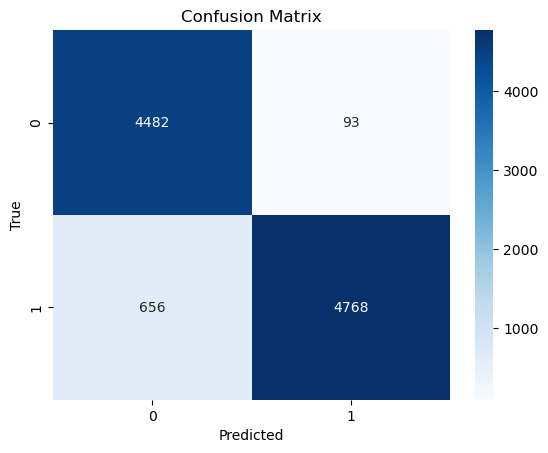

In [305]:
# 测试模型
# 你可以调整batch_size，如1000、5000、甚至一次性预测
test_csv_path = 'NSL_KDD_PGD_Adversarial.csv'
acc, precision, recall, f1 = test_model(model, test_csv_path, select_features, batch_size=1000)